# Modelos: K-Arm Bandit + Thompson sampling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH     = '../..'
LIB_PATH      = f'{BASE_PATH}/lib'
DATASET_PATH  = f'{BASE_PATH}/datasets'
WEIGHTS_PATH  = f'{BASE_PATH}/weights'
STACKING_PATH = f'{DATASET_PATH}/stacking'

METRICS_PATH  = f'{BASE_PATH}/metrics/bandit'

MODELS        = [
    'knn_user',
    'knn_item',
    'knn_ensemble',
    'gmf',
    'biased_gmf',
    'nnmf',
    'deep_fm',
    'cb_user_profile'
]

In [3]:
import sys
sys.path.append(LIB_PATH)

import pytorch_common.util as pu

import data.dataset as ds
import data.plot as pt

import numpy as np
import pandas as pd
import model as ml

import util as ut

import logging

from abc import ABC, abstractmethod

import seaborn as sns
import matplotlib.pyplot as plt

from data import progress_bar

2023-12-09 11:34:16.230310: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 11:34:16.624783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-09 11:34:17.011772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-09 11:34:17.021042: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GP

<Figure size 640x480 with 0 Axes>

## Helper classes

Preditor base on an static datatable:

In [4]:
def load_dataset(path, models, post_fix):
    datasets = []
    for model in MODELS:
        ds = ut.load_df(f'{path}/{model}_{post_fix}.json')
        ds['model'] = model
        datasets.append(ds)

    return pd.concat(datasets)


def build_dataset(df):
    df = df.pivot(
        index=['user_id', 'movie_id', 'rating'],
        columns='model',
        values=['prediction']
    )
    df.columns = df.columns.droplevel(0)
    return df.reset_index(names=['user_id', 'movie_id', 'rating']).dropna()

In [5]:
def create_dataset(df):
    return ds.BasicDataset(
        df, 
        feature_cols = ['user_id', 'movie_id'], 
        target_col   = 'rating', 
        feat_type    = torch.long
    )

def create_data_loader(df):
    return DataLoader(
        create_dataset(df),
        batch_size  = 256,
        num_workers = 24,
        pin_memory  = True,
        shuffle     = False
    )

# Model classes

In [6]:
class SuccessSelector(ABC):
    def __call__(self, df, model):
        return 0 if df.empty else len(self._perform(df, model))

    @abstractmethod
    def _perform(self, df, model):
        pass

    
class RangeSuccessSelector(SuccessSelector):
    def __init__(
        self,
        start = 0.5,
        end   = 0.5,
        rating_col = 'rating'
    ):
        self.__start      = start
        self.__end        = end
        self.__rating_col = rating_col

    def _perform(self, df, model):
        return df[
            (df[model] >= (df[self.__rating_col] - self.__start)) & 
            (df[model] <= (df[self.__rating_col] + self.__end))
        ]

In [7]:
class UserModelBandit:
    def __init__(
        self, 
        model, 
        user_id,
        success_selector,
        sample_size      = 5, 
        seed             = 42,
        beta_sample_size = 3
    ):
        self.model              = model
        self.user_id            = user_id
        self.__success_selector = success_selector 
        self.__sample_size      = sample_size
        self.__seed             = seed
        self.__beta_sample_size = beta_sample_size

        self.__rnd              = np.random.RandomState(self.__seed)

        self.n_success           = 0
        self.n_fails             = 0        
        self.success_prob        = 0



    def __sample(self, data):
        interactions = data[(data.user_id == self.user_id)]

        if len(interactions) == 0:
            return interactions
        else:
            return interactions.sample(
                n            = self.__sample_size, 
                replace      = True,
                random_state = self.__seed
            )


    def pull_arm(self, data):
        self.n_success = self.__success_selector(
            self.__sample(data),
            self.model
        )
        self.n_fails   = abs(self.n_success - self.__sample_size)

        self.success_prob = self.__rnd.beta(
            self.n_success + 1, 
            self.n_fails   + 1, 
            size = self.__beta_sample_size
        ).mean()

        return self.success_prob
        
            
class UserModelBanditGroup:
    def __init__(
        self,
        models,
        success_selector,
        sample_size      = 5, 
        seed             = 42,
        beta_sample_size = 1,
    ):
        self.models           = models
        self.success_selector = success_selector
        self.sample_size      = sample_size 
        self.seed             = seed
        self.beta_sample_size = beta_sample_size
        self.bandits          = {}


    def __create_bandit(self, model, user_id):
        return UserModelBandit(
            model,
            user_id,
            self.success_selector,
            self.sample_size,
            self.seed,
            self.beta_sample_size
        )

    def bandits_by_user(self, user_id):
        if user_id in self.bandits:
            return self.bandits[user_id]
        else:
            bandits = [self.__create_bandit(model, user_id) for model in self.models]
            self.bandits[user_id] = bandits
            return bandits

    

class ExperimentResult:
    def __init__(self, train_df, bandits):
        self.train_df = train_df
        self.bandits  = bandits


    @property
    def model_probs(self):
        return self.probs.groupby(['model']).mean().reset_index()[['model', 'prob']]


    @property
    def probs(self):
        results = []
        for bandits in self.bandits.values():            
            for bandit in bandits:
                results.append({
                    'user_id': bandit.user_id,
                    'model'  : bandit.model,
                    'prob'   : bandit.success_prob
                })
        return pd.DataFrame(results)


    @property
    def max_probs(self):
        return self.probs.groupby(['user_id']).max().reset_index()
    
    
    def plot_model_succes_probs(self):
        return sns.barplot(
            self.model_probs.sort_values('prob', ascending=False), 
            x="model",
            y="prob"
        ) .set(title='Models success hist')


    def plot_user_interactions(self):
        df = self.model_probs \
            .groupby(['user_id'])['rating'] \
            .count() \
            .reset_index() \
            .rename(columns={'rating': 'n_interactions'}) \
            .sort_values(['n_interactions'], ascending=False) \
 
    def comparative_boxplot(self):
        return pt.comparative_boxplot(result.probs, y='model', x='prob')

    def models_boxplot(self):
        probs_df = result.probs
        for model in MODELS:
            pt.describe_num_var(
                probs_df[probs_df.model == model],
                column = 'prob',
                title  = f'{model} dist'
            )
            plt.show()
    
    def plot_model_distributons(self):
        sns.displot(
            result.probs,
            x         = 'prob',
            kind      = 'kde',
            hue       = 'model',
            fill      = True,
            bw_adjust = 2,
            height    = 8.27,
            aspect    = 11.7/8.27,
            warn_singular = False
        ).set(title   = 'Models success dist')


In [8]:
class EpsilonGreedySelectionStrategy:
    def __init__(self, exploration_prob):
        self.exploration_prob = exploration_prob

    def select(self, bandits):
        if np.random.normal() < self.exploration_prob:
            return bandits[np.random.randint(0, len(bandits))]  # Random action
        else:
            return bandits[np.argmax([b.success_prob for b in bandits])]

    def decrease_exploration(self, delta):
        self.exploration_prob -= delta

In [9]:
class Experiment:
    def __init__(
        self,
        train_df,
        models,
        success_selector     = RangeSuccessSelector(),
        select_strategy      = EpsilonGreedySelectionStrategy(exploration_prob=0.8),
        exploration_decrease = 0.01,
        sample_size          = 10,
        seed                 = 42,
        beta_sample_size     = 20,
        n_episodes           = 800
    ):
        self.groups = UserModelBanditGroup(
            models,
            success_selector,
            sample_size,
            seed,
            beta_sample_size,
        )
        self.select_strategy      = select_strategy
        self.exploration_decrease = exploration_decrease
        self.n_episodes           = n_episodes
        self.user_ds              = train_df.user_id.unique()


    def perform(self, test_df):
        with progress_bar(self.n_episodes, 'Episodes') as bar:
            for _ in  range(self.n_episodes):
                for user_id in self.user_ds:
                    bandits = self.groups.bandits_by_user(user_id)
                    bandit  = self.select_strategy.select(bandits)
                    bandit.pull_arm(test_df)

                self.select_strategy.decrease_exploration(self.exploration_decrease)
                bar.update()

        return ExperimentResult(test_df, self.groups.bandits)

## Setup

In [10]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

# Experiments

In [11]:
train_df = build_dataset(load_dataset(STACKING_PATH, MODELS, 'train'))
test_df  = build_dataset(load_dataset(STACKING_PATH, MODELS, 'test'))

In [12]:
result = Experiment(
    train_df,
    models               = MODELS,
    success_selector     = RangeSuccessSelector(start = 0.5, end = 1.0)
).perform(test_df)

Episodes:   0%|          | 0/800 [00:00<?, ?it/s]

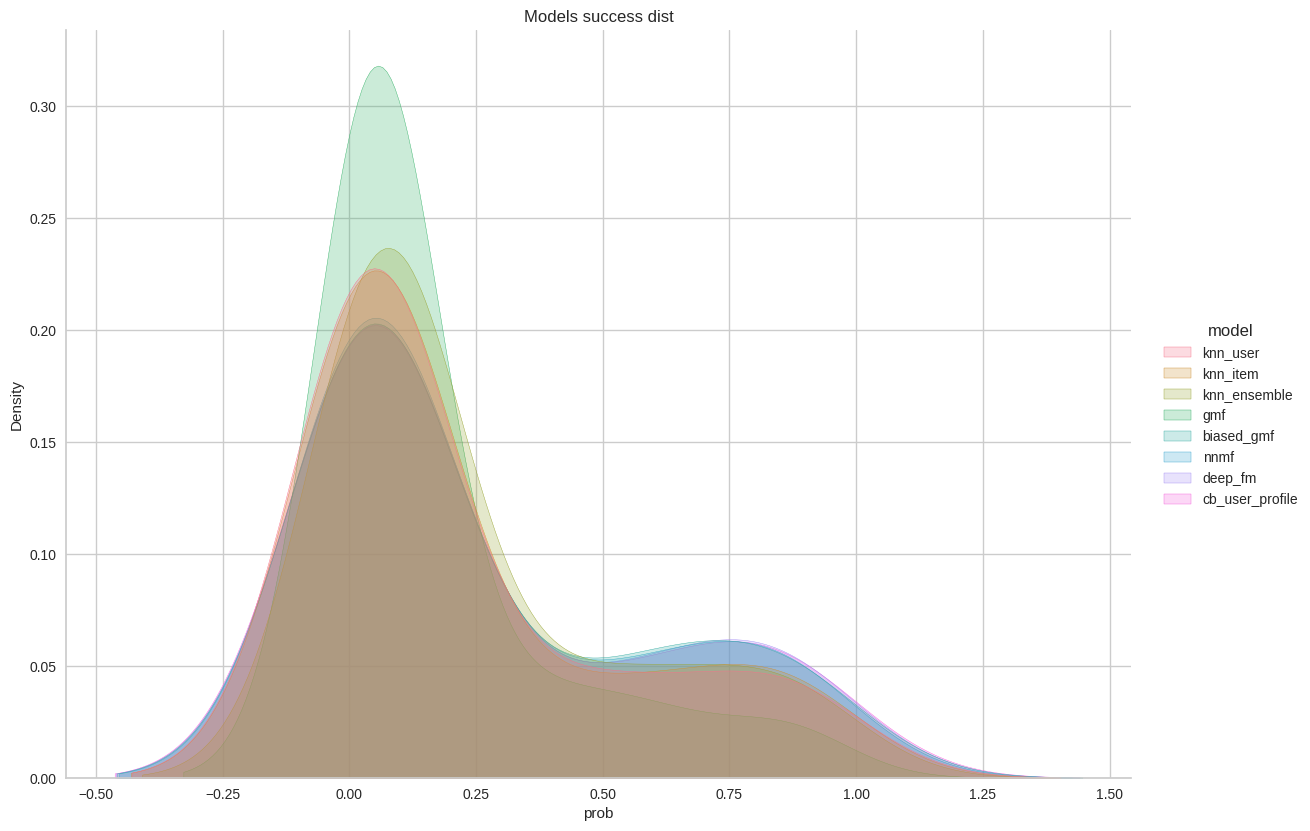

In [13]:
result.plot_model_distributons()

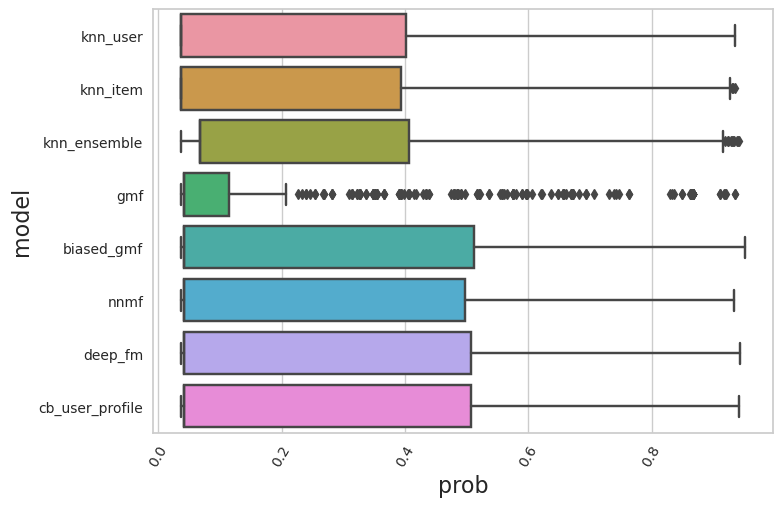

In [14]:
result.comparative_boxplot()

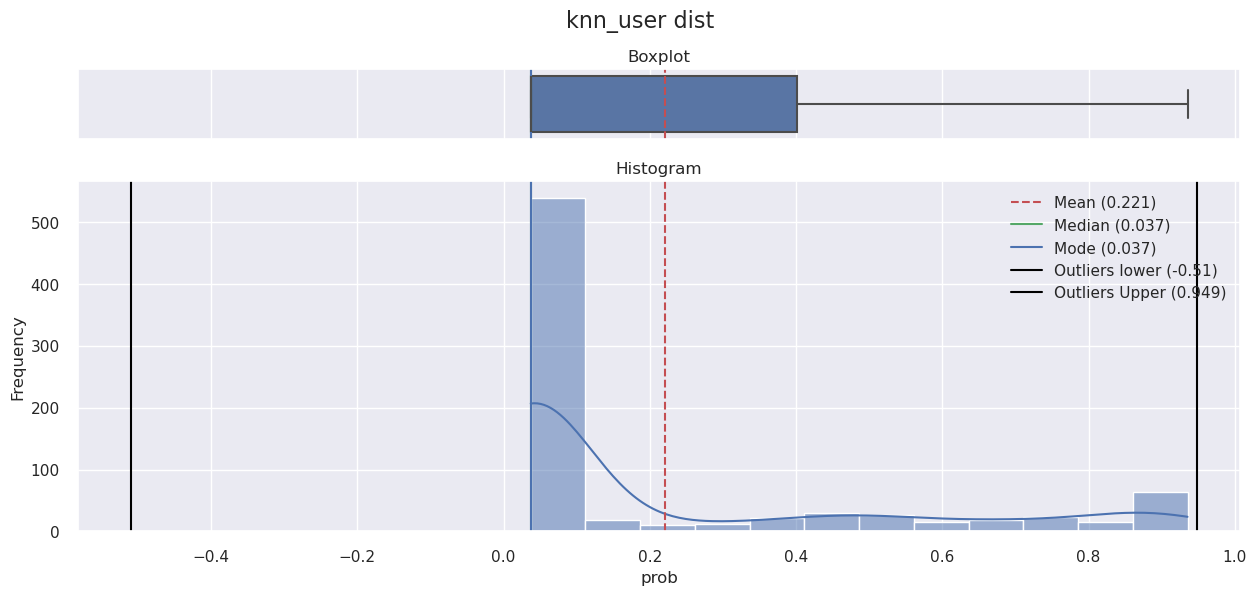

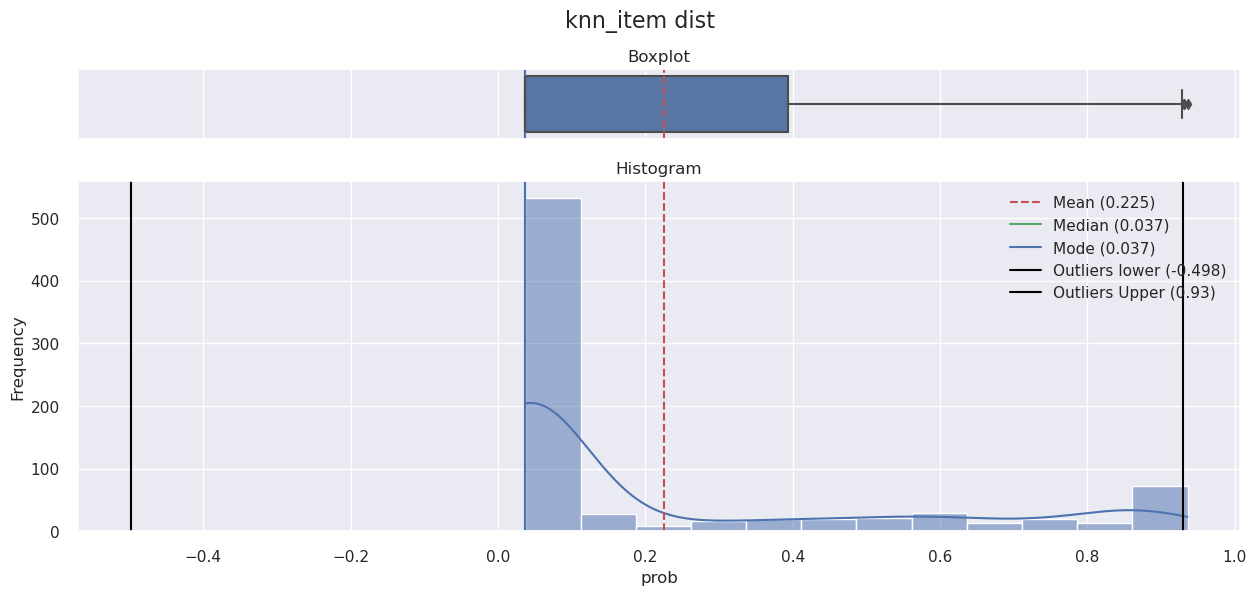

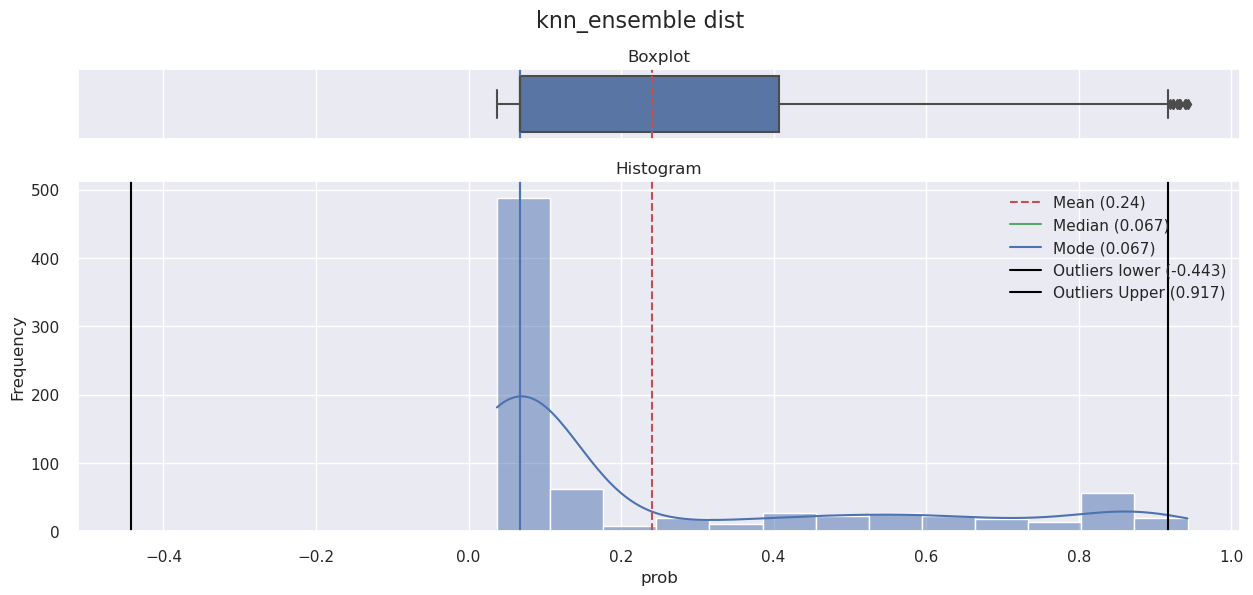

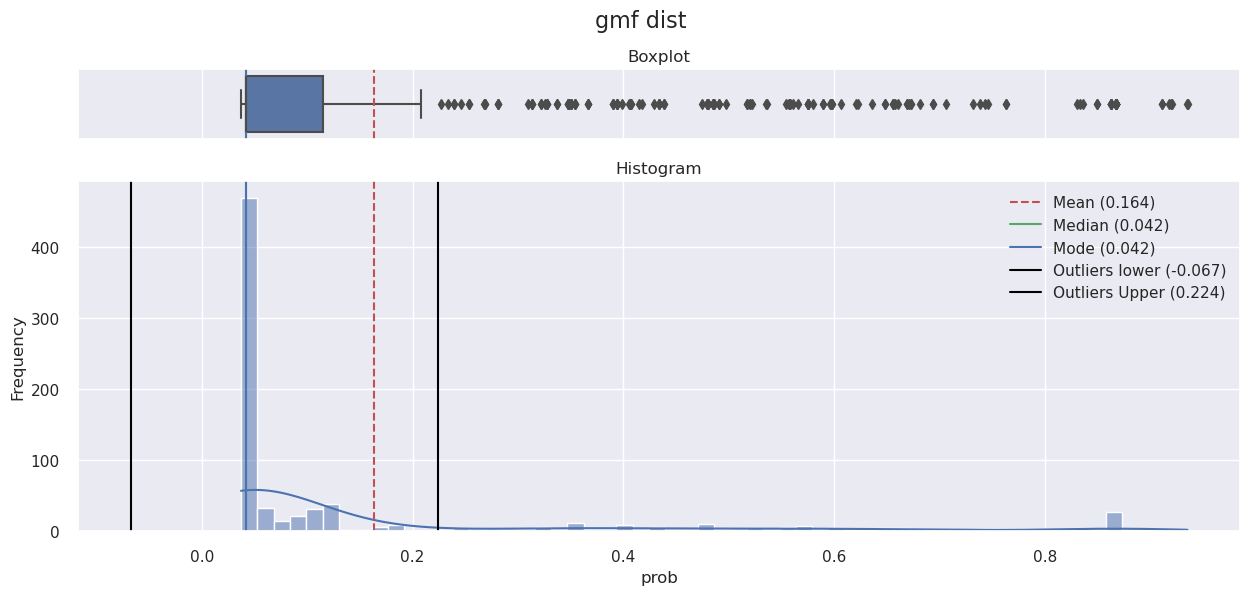

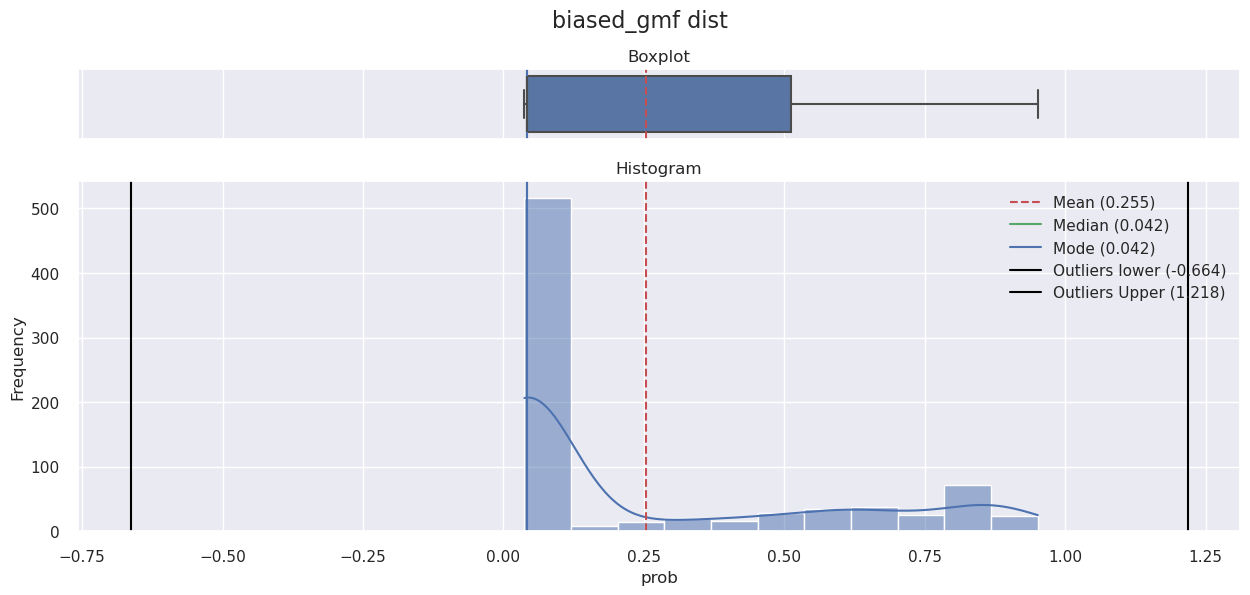

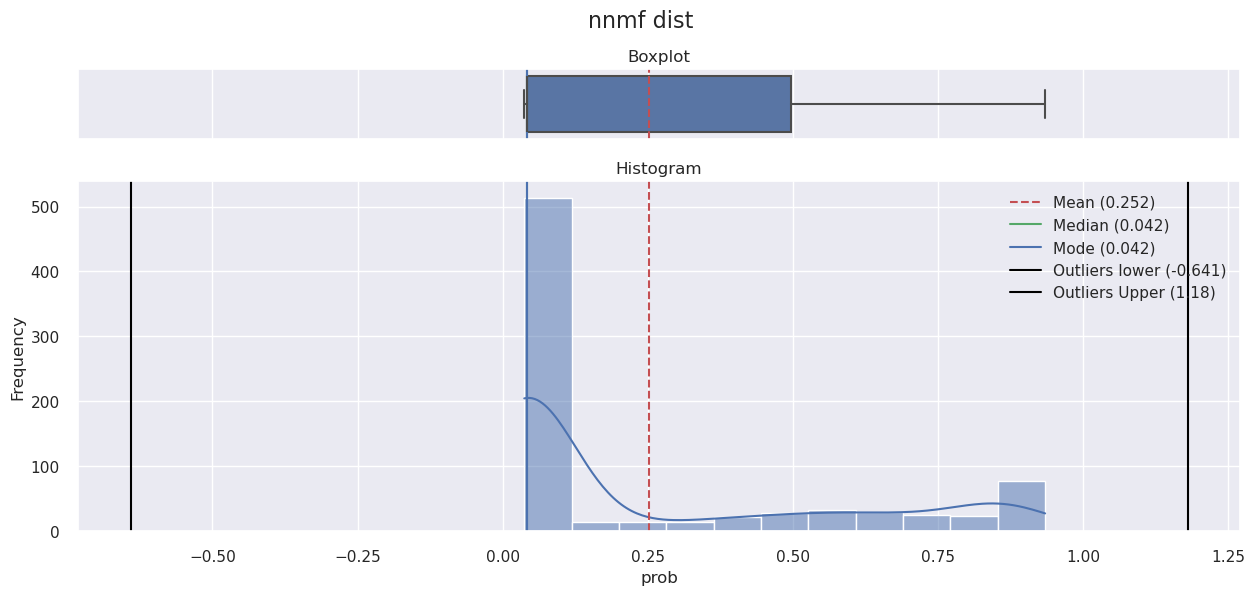

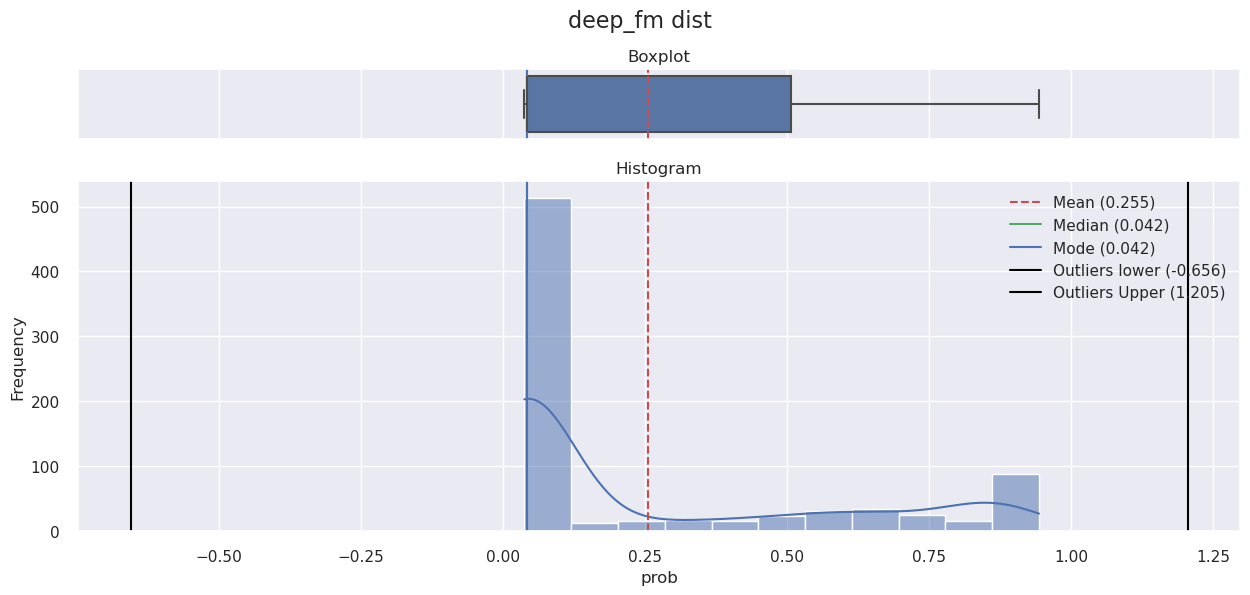

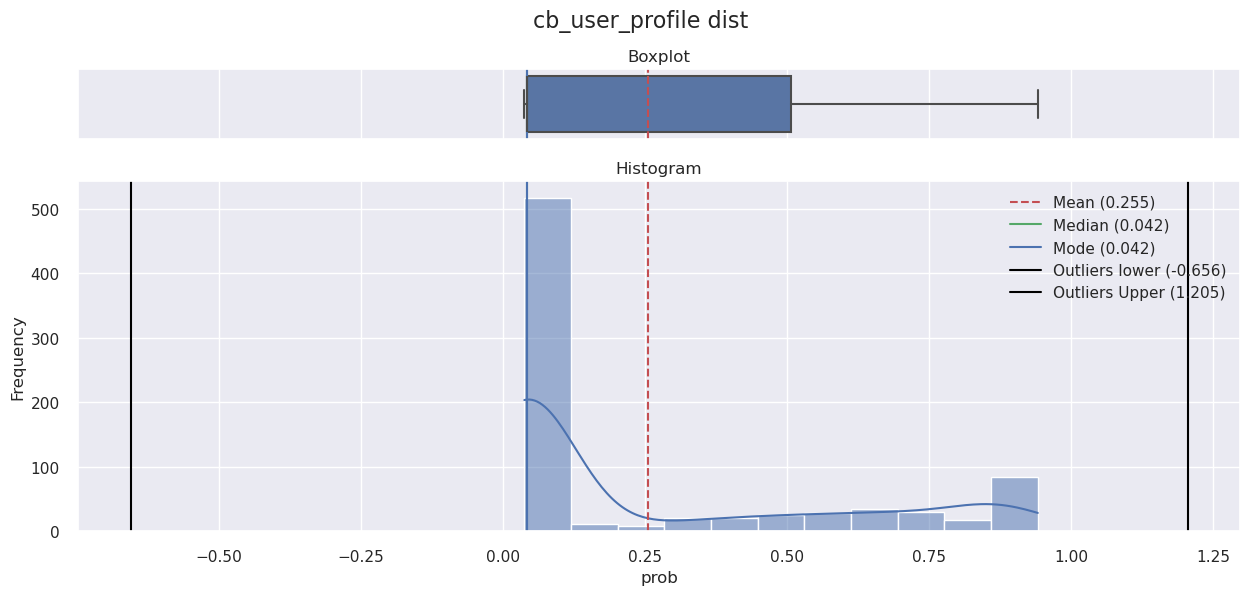

In [15]:
result.models_boxplot()